# How should we analyse property vacancy rates? A case study using simulated data

Vacancy rates provide insights into the economic health of specific property types or classes, such as retail. However, assessing these rates in isolation can be misleading. For instance, a surge in retail vacancy rates might be mistakenly attributed to specific industry shifts, such as e-commerce growth. But, in fact, it might reflect wider economic trends that impact all property classes. A solution is to create a relative vacancy rate ratio that benchmarks vacancies for a property class of interest against a local average. 

This script engineers a feature - the "relative vacancy rate" - that describes the economic performance of high-street retail property relative to a local average. It does so for several cities and models how relative vacancy rate responds in each when exposed to an economic shock.


# Simulation, feature engineering, visualisation, and modelling


**Let's begin by loading in packages**

In [17]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(ggthemes)
library(ggsci)
library(mgcv)
library(ggpubr)


**Now we'll simulate 5 years of vacancy rate data for 4 property classes in 3 cities**

**We'll introduce an economic shock after two years that hits high-street retail hardest, especially in manchester**

In [2]:
# create parameters
n_years <- 5
n_months <- 12
n_cities <- 3 # 1 = Bristol, 2 = London, 3 = Manchester
n_property_classes <- 4  # 1 = residential, 2 = commercial, 3 = high street retail, Industrial = 4


In [3]:
# create data frame to store simulated data
vacancy_data <- data.frame(
  year = integer(),
  month = integer(),
  city = factor(),
  property_class = factor(),
  vacancy_rate = numeric()
)

In [4]:
# generate data
set.seed(50) # first set seed
time_id <- 0
for (year in 1:n_years) {
  for (month in 1:n_months) {
    time_id <- time_id + 1
    for (city in 1:n_cities) {
      for (property_class in 1:n_property_classes) {
        
        # base vacancy rate
      
        base_vacancy_rate <- min(max(rnorm(1, mean = 5, sd = 1), 2), 8)

        
        # add economic shock after 2 years (24 time periods)
        economic_shock <- ifelse(time_id > 24 & time_id < 48, pmax(0, rnorm(1, 4, 1)), 0)
        
        # make the economic shock worse for manchester
        if (city == 3) {
          economic_shock <- economic_shock * 3  # we'll pick an extreme multiplier for illustrative purposes
        }
        
        # add differential impact by property class
        if (property_class == 3) {
          economic_shock <- economic_shock * 2 
        } else {
          economic_shock <- economic_shock * 1
        }

        # final vacancy rate
        vacancy_rate <- base_vacancy_rate + economic_shock
        
        # store data
        vacancy_data <- rbind(vacancy_data, c(year, month, city, property_class, vacancy_rate))
        colnames(vacancy_data) <- c("year", "month", "city", "property_class", "vacancy_rate")

      }
    }
  }
}

**Now let's check that our data looks right**

In [5]:
# inspect first 5 rows
head(vacancy_data, 5)

,year,month,city,property_class,vacancy_rate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,1,5.549670
2,1,1,1,2,4.158396
3,1,1,1,3,5.032998
4,1,1,1,4,5.524150
5,1,1,2,1,3.272396


In [6]:
# do we get the expected number of unique values in each col?
lapply(vacancy_data, function(x) length(unique(x)))

$year
[1] 5

$month
[1] 12

$city
[1] 3

$property_class
[1] 4

$vacancy_rate
[1] 719

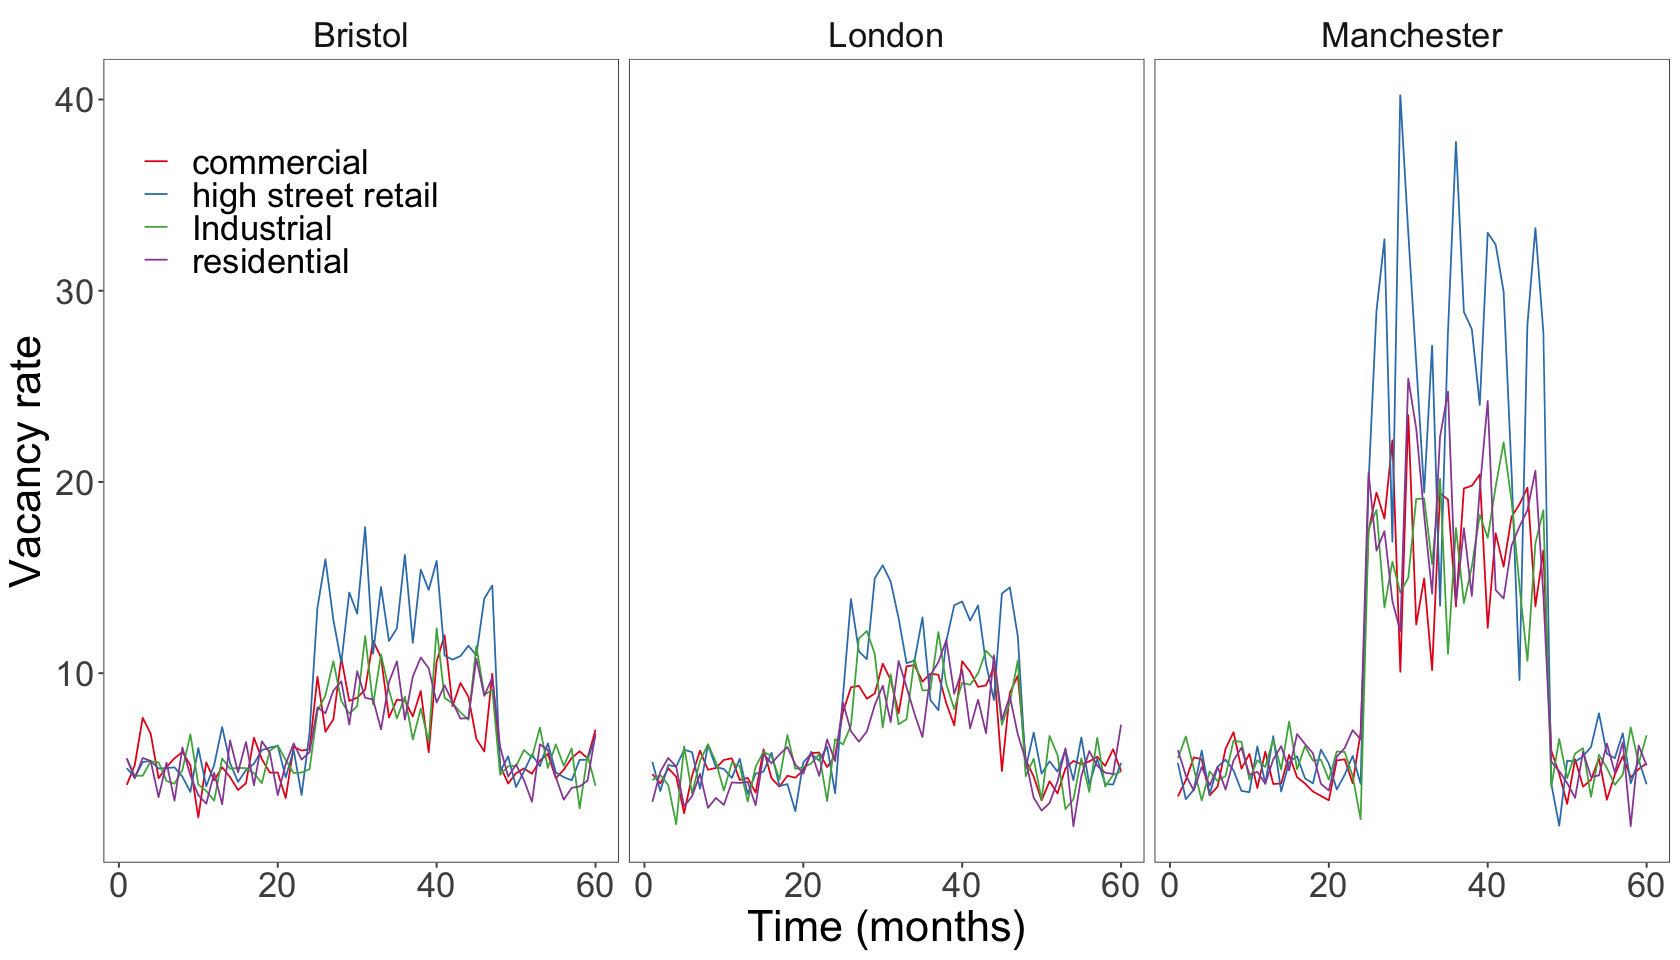

In [7]:
vacancy_data1 <- vacancy_data %>%
  group_by(city, property_class) %>%
  mutate(time = seq(1, 60)) %>% 
  ungroup() %>%
  mutate(city = case_when(
      city == 1 ~ "Bristol",
      city == 2 ~ "London",
      city == 3 ~ "Manchester"),
      property_class = case_when(
      property_class == 1 ~ "residential",
      property_class == 2 ~ "commercial",
      property_class == 3 ~ "high street retail",
      property_class == 4 ~ "Industrial")) %>% 
    data.table()

# adjust plot width
options(repr.plot.width=14, repr.plot.height=8)

ggplot(vacancy_data1, aes(y = vacancy_rate, x = time, colour = factor(property_class))) +
geom_line() + theme_few() + scale_color_brewer(name = "", palette = "Set1") +
theme(text = element_text(size = 26), 
      legend.position = c(0.12, 0.85)) + labs(y = "Vacancy rate", x = "Time (months)") + 
facet_wrap(~city)

**The economic shock affects vacancy rates in all cities for all property classes but is most pronounced in Manchester and in high-street retail**

**But it'd be more useful to get a direct numerical comparison across groups**

**Now we'll do some feature engineering. For each city, we'll divide vacancy rates in high-street property by the average of the other local property classes, creating a relative vacancy ratio for the high street**

**Relative_vacancy_ratio interpretation:** 
* above 1 means high street vacnancy is above local benchmark
* below 1 means high street vacnancy is below local benchmark
* at 1 means high street vacnancy is the same (i.e., parity)

In [8]:
# we'll compute vancancy rate for each month in each city
vacancy_data2 <- vacancy_data1 %>% group_by(city, year, month) %>% 
  mutate(local_vacancy_rate_benchmark = mean(vacancy_rate[!property_class == "high street retail"]), 
         relative_vacancy_ratio = vacancy_rate[property_class == "high street retail"]/local_vacancy_rate_benchmark) %>%
  data.table()

# then we'll clean the dataset and set city names
vacancy_data2 <- vacancy_data2 %>% filter(property_class == "high street retail") %>% 
  group_by(city) %>%
  mutate(city_mean = mean(relative_vacancy_ratio, na.rm = T)) %>%
data.table()


**Let's visualise the distribution of relative_vacancy_ratio by city**

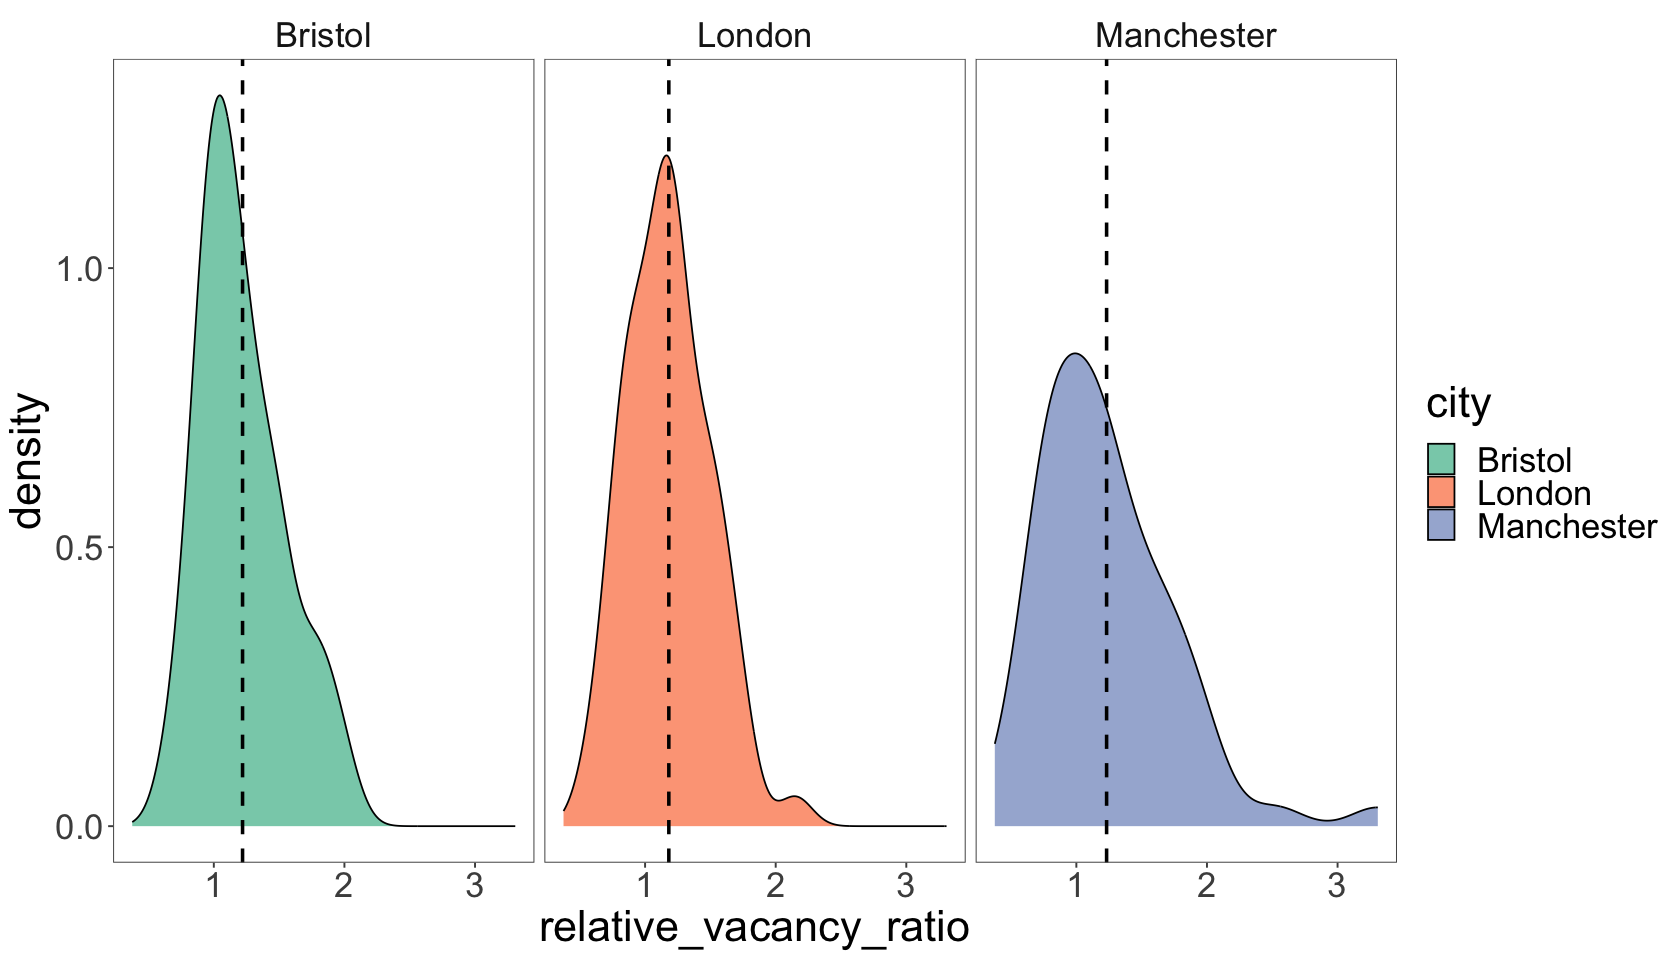

In [18]:
vacancy_data2 %>% ggplot(aes(x = relative_vacancy_ratio, fill = city)) + 
geom_density(alpha = 0.8, colour = "black") +
scale_fill_brewer(name = "city", palette = "Set2") +
geom_vline(data = vacancy_data2, aes(xintercept = city_mean), 
           color = "black", linetype="dashed", size = 1) +
theme_few() +
theme(text = element_text(size = 26)) + 
facet_grid(~city)



**Now let's inspect it statistically**

In [10]:
vacancy_data2 %>% group_by(city) %>% 
summarise(mean = mean(relative_vacancy_ratio), sd = sd(relative_vacancy_ratio))

city,mean,sd
<chr>,<dbl>,<dbl>
Bristol,1.220063,0.3246441
London,1.181766,0.3179978
Manchester,1.231584,0.5136177


**And we'll create a plot visualising the change in high-street relative vacancy ratio by city**

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


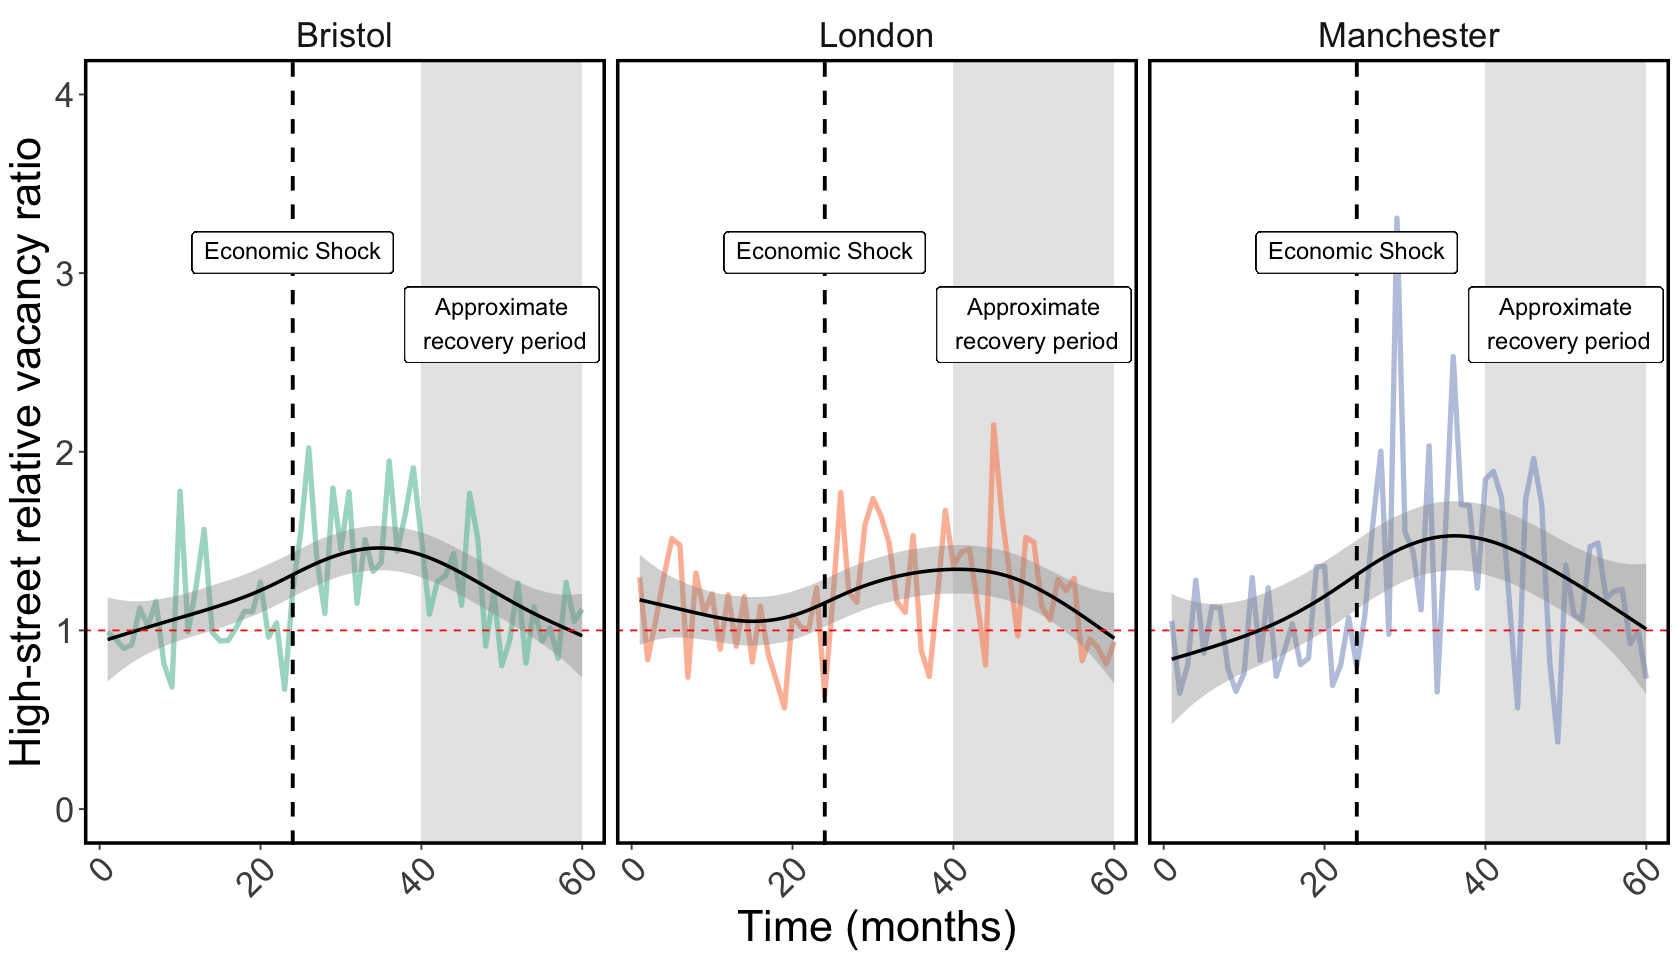

In [19]:
# create final plot
(plot <- ggplot(vacancy_data2, aes(x = time, y = relative_vacancy_ratio)) +
geom_rect(aes(xmin = 40, xmax = 60, ymin = -Inf, ymax = Inf), 
            fill = "grey90", alpha = 0.1) +
   geom_label(aes(x = 50, y = 2.5, label = "Approximate\n recovery period"), 
           angle = 90, vjust = 0, size = 5, 
           label.padding = unit(0.5, "lines")) +
  geom_line(aes(color = city), alpha = 0.6, size = 1.5) +
  geom_smooth(se = TRUE, colour = "black", size = 1, method = "gam") +
  facet_grid(~ city) +
  xlab("Time (months)") +
  theme_few() +
  scale_y_continuous(limits = c(0, 4), breaks = seq(0,4)) +
  geom_vline(xintercept = 24, linetype = "dashed", colour = "black", size = 1) +
  geom_hline(yintercept = 1, linetype = "dashed", colour = "red") +
  ylab("High-street relative vacancy ratio") +
  scale_color_brewer(name = "city", palette = "Set2") +
  theme(text = element_text(size = 26)) + 
  geom_vline(xintercept = 24, linetype = "dashed", colour = "black", size = 1) +
  geom_label(aes(x = 24, y = 3, label = "Economic Shock"), 
           angle = 90, vjust = 0, size = 5, 
           label.padding = unit(0.5, "lines"))+
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "NA",
      panel.border = element_rect(colour = "black", fill=NA, size=2)
  ))

**We can see from the raw data that recovery begins around month 40, but let's now use a model to identify the precise point at which recovery begins for each city**

**We'll model the relative vacancy ratio over time for each city and then identify the point on the curve at which the slope becomes negative**

In [12]:
# fit models
Manchester_model <- gam(relative_vacancy_ratio ~ s(time, bs = "cs"), data = vacancy_data2[city == "Manchester"])
Bristol_model <- gam(relative_vacancy_ratio ~ s(time, bs = "cs"), data = vacancy_data2[city == "Bristol"])
London_model <- gam(relative_vacancy_ratio ~ s(time, bs = "cs"), data = vacancy_data2[city == "London"])


**Now create a function to get first derivatives and find points of slope descent** 

In [13]:
f <- function(model, data){
    time_seq <- seq(min(data$time), max(data$time), length.out = 1000)
    newdata <- data.frame(time = time_seq)
    pred <- predict(model, newdata = newdata)

    # get first derivative manually using finite differences
    deriv1 <- diff(pred) / diff(time_seq)

    # find where the first derivative crosses from positive to negative
    zero_cross <- which(diff(sign(deriv1)) == -2) + 1

    descent_time <- time_seq[zero_cross]
    descent_vacancy <- pred[zero_cross]

    return(list(descent_time = descent_time, descent_vacancy = descent_vacancy))
}

In [20]:
# run function across model list
models_list <- list(Manchester = Manchester_model, Bristol = Bristol_model, London = London_model)
(deriv_df <- data.frame(lapply(models_list, f, data = vacancy_data2))[3,])


Warning message in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, :
“row names were found from a short variable and have been discarded”


,Manchester.descent_time,Manchester.descent_vacancy,Bristol.descent_time,Bristol.descent_vacancy,London.descent_time,London.descent_vacancy
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,35.84484,1.58358,34.84084,1.52214,46.003,1.387374


 **Now that we've got the points at which high-street relative vacancy ratio begins to decline following the economic shock, we can update our previous plots**


    

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


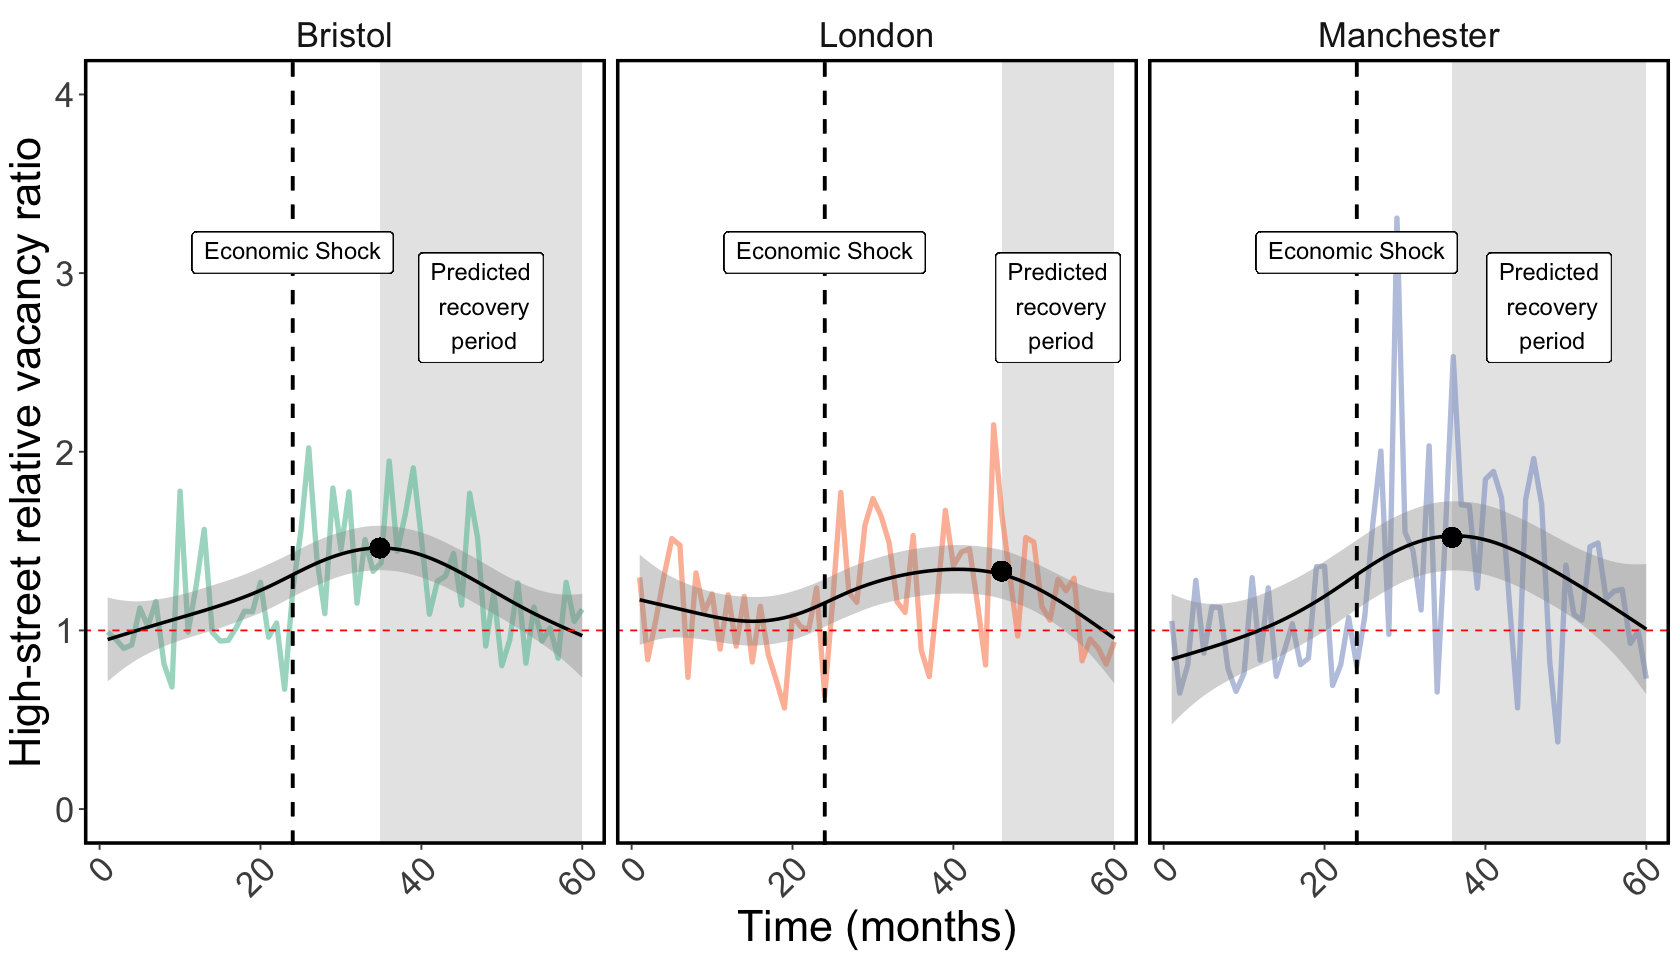

In [21]:
vacancy_data3 <- vacancy_data2 %>% 
mutate(curve_descent_time = case_when(city == "Manchester" ~ deriv_df[1,1],
                                      city == "Bristol" ~ deriv_df[1,3],
                                      city == "London" ~ deriv_df[1,5]),
      curve_descent_vacancy = case_when(city == "Manchester" ~ 0.96*deriv_df[1,2],
                                       city == "Bristol" ~ 0.96*deriv_df[1,4],
                                       city == "London" ~ 0.96*deriv_df[1,6]))


(final_plot <- ggplot(vacancy_data3, aes(x = time, y = relative_vacancy_ratio)) +
geom_rect(data = vacancy_data3, aes(xmin = curve_descent_time, xmax = 60, ymin = -Inf, ymax = Inf), 
            fill = "grey90", alpha = 0.1) +
   geom_label(aes(x = curve_descent_time + ((60-curve_descent_time)/2), y = 2.5, label = "Predicted\n recovery\n period"), 
           angle = 90, vjust = 0, size = 5, 
           label.padding = unit(0.5, "lines")) +
  geom_line(aes(color = city), alpha = 0.6, size = 1.5) +
  geom_smooth(se = TRUE, colour = "black", size = 1, method = "gam") +
  facet_grid(~ city) +
  xlab("Time (months)") +
 geom_point(data = vacancy_data3, size = 5,
                  aes(x = curve_descent_time, y = curve_descent_vacancy)) +
  theme_few() +
  scale_y_continuous(limits = c(0, 4), breaks = seq(0,4)) +
  geom_vline(xintercept = 24, linetype = "dashed", colour = "black", size = 1) +
  geom_hline(yintercept = 1, linetype = "dashed", colour = "red") +
  ylab("High-street relative vacancy ratio") +
  scale_color_brewer(name = "city", palette = "Set2") +
  theme(text = element_text(size = 26)) + 
  geom_vline(xintercept = 24, linetype = "dashed", colour = "black", size = 1) +
  geom_label(aes(x = 24, y = 3, label = "Economic Shock"), 
           angle = 90, vjust = 0, size = 5, 
           label.padding = unit(0.5, "lines"))+
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "NA",
      panel.border = element_rect(colour = "black", fill=NA, size=2)
  ))
            


**The plots show that the effect of the economic shock varies in its duration and is more pronounced in some cities than others**

**But are the differences between cities statistically significant? Let's fit a simple model to find out if the relative vacancy ratio is different in the pre- and post-shock environments and whether this varies by city**

In [16]:
# create an indicator for time period after the shock
vacancy_data2 <- vacancy_data2 %>% group_by(city) %>%
  mutate(post_shock = ifelse(time > 24, 1, 0))

# fit a linear regression with an interaction term for post-shock and city
its_model <- lm(relative_vacancy_ratio ~ post_shock*city, data=vacancy_data2)
summary(its_model)


Call:
lm(formula = relative_vacancy_ratio ~ post_shock * city, data = vacancy_data2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.04096 -0.21160 -0.04641  0.18948  1.89152 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.05919    0.07406  14.301  < 2e-16 ***
post_shock                 0.26812    0.09561   2.804  0.00562 ** 
cityLondon                -0.01228    0.10474  -0.117  0.90684    
cityManchester            -0.10508    0.10474  -1.003  0.31716    
post_shock:cityLondon     -0.04337    0.13522  -0.321  0.74880    
post_shock:cityManchester  0.19433    0.13522   1.437  0.15247    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3628 on 174 degrees of freedom
Multiple R-squared:  0.1769,	Adjusted R-squared:  0.1533 
F-statistic:  7.48 on 5 and 174 DF,  p-value: 2.208e-06


# Interpretation
The economic shock significantly increases the relative vacancy ratio on average (p = 0.005), indcating that, compared to other local property types, high-street retail sufered the most. However, the effect does not differ between Bristol (reference city) and London but is far larger in Manchaster, although the effect only approaches statistical significance (p = 0.15).

# Methodological takeaways
Performance is often most meaningful when compared to a reference point. By creating a relative performance ratio, you can isolate the effects of a feature of interest and compare it directly to the reference group using a single statistic that's is easy to interpret, model, and plot 